In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier

In [2]:
original_articles = pd.read_csv('combined_articles.csv')
original_comments = pd.read_csv('combined_comments.csv')

D:\Utilities\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
articles = original_articles.copy()
comments = original_comments.copy()

comments = comments[comments['depth'] == 1]
comments.drop(['Unnamed: 0', 'articleWordCount', 'commentID', 'commentType', 'inReplyTo', 'editorsSelection', 'sharing', 'timespeople', 'trusted', 'userID', 'approvalInterval', 'replyCount', 'userLocation', 'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'sectionName', 'userDisplayName', 'updateDate', 'depth', 'printPage'], axis = 1, inplace = True)
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678196 entries, 0 to 877353
Data columns (total 7 columns):
approveDate        678196 non-null object
articleID          678196 non-null object
commentBody        678196 non-null object
createDate         678196 non-null object
newDesk            678196 non-null object
recommendations    678196 non-null int64
typeOfMaterial     678196 non-null object
dtypes: int64(1), object(6)
memory usage: 41.4+ MB


In [4]:
gb = comments.groupby('newDesk')['recommendations']

tertile_1 = {k: v for k, v in zip(gb.quantile(1/4).index, gb.quantile(1/4).values)}
tertile_2 = {k: v for k, v in zip(gb.quantile(3/4).index, gb.quantile(3/4).values)}

def retTertile1(series):
    return tertile_1[series['newDesk']]

def retTertile2(series):
    return tertile_2[series['newDesk']]
    
comments['cat_tertile_1'] = comments.apply(retTertile1, axis = 1)
comments['cat_tertile_2'] = comments.apply(retTertile2, axis = 1)
comments['recommendations'] = (comments['recommendations'] > comments['cat_tertile_1']).apply(int) + (comments['recommendations'] > comments['cat_tertile_2']).apply(int)

comments['approveDate'] = comments['approveDate'].astype('datetime64[ns]')
comments = comments.merge(articles[['articleID', 'pubDate']], on ='articleID')
comments['pubDate'] = comments['pubDate'].astype('datetime64[ns]')
comments['age'] = (comments['pubDate'] - comments['approveDate']).dt.seconds

comments['approveHour'] = comments['approveDate'].dt.hour
comments['approveDay'] = comments['approveDate'].dt.day

comments.drop(['cat_tertile_1', 'cat_tertile_2'], axis = 1, inplace = True)

# First Pass Modelling

In [5]:
cont_model = RandomForestClassifier(n_estimators = 30, min_samples_split = 10)

modelling_df = pd.get_dummies(comments, drop_first = True, columns = ['newDesk', 'approveDay', 'approveHour']).loc[:, 'age':]
target = comments['recommendations']

train_indices = modelling_df.sample(frac = 0.7).sort_index().index
test_indices = modelling_df.iloc[~modelling_df.index.isin(train_indices)].index

scaling_columns = ['age']

for col in scaling_columns:
    col_mean = modelling_df[col].mean()
    col_std = modelling_df[col].std()
    modelling_df[col] = (modelling_df[col] - col_mean) / col_std

cont_train_X, cont_test_X = modelling_df.iloc[train_indices], modelling_df.iloc[test_indices]
train_y, test_y = target[train_indices], target[test_indices]

In [6]:
# cont_model = XGBClassifier(objective = 'multi:softmax', eta = 0.6, max_depth = 25, min_child_weight = 3, num_class = 3)

pipeline = Pipeline(steps = (('vt', VarianceThreshold(0.02)),
                             ('model', cont_model)))
pipeline.fit(cont_train_X, train_y)
cont_pred_y = pipeline.predict(cont_test_X)
pipeline.score(cont_test_X, test_y)
print(classification_report(test_y, cont_pred_y))
pd.DataFrame(confusion_matrix(test_y, cont_pred_y), index = ['true_{}'.format(i) for i in range(3)], columns = ['pred_{}'.format(j) for j in range(3)])

             precision    recall  f1-score   support

          0       0.65      0.57      0.61     56300
          1       0.62      0.70      0.66     93468
          2       0.62      0.56      0.59     47107

avg / total       0.63      0.63      0.63    196875



,pred_0,pred_1,pred_2
true_0,32040,21536,2724
true_1,14763,64968,13737
true_2,2590,17915,26602


In [7]:
feature_importances = pd.Series(cont_model.feature_importances_, index = modelling_df.columns[modelling_df.var() > 0.02]).sort_values(ascending = False)
feature_importances.head(20)

age                   0.738273
newDesk_Learning      0.035218
newDesk_OpEd          0.009655
newDesk_Washington    0.008978
newDesk_National      0.006445
newDesk_Foreign       0.005770
approveHour_15        0.005637
newDesk_Business      0.005619
approveDay_26         0.005253
approveDay_27         0.005240
approveDay_21         0.005164
approveDay_5          0.004978
approveDay_20         0.004977
newDesk_Editorial     0.004973
approveDay_24         0.004868
approveDay_12         0.004829
approveDay_30         0.004828
approveDay_17         0.004801
approveDay_23         0.004784
approveDay_13         0.004777
dtype: float64

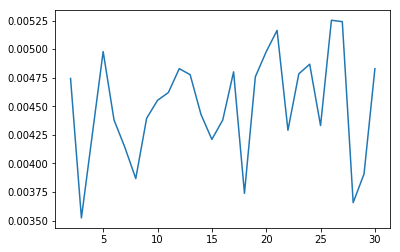

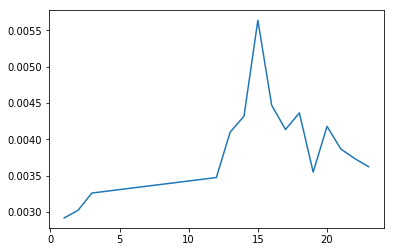

In [8]:
day_importances = feature_importances[feature_importances.index.str.contains('Day')]
day_importances.index = day_importances.index.str.replace('approveDay_', '').astype(int)
day_importances.sort_index().plot()
plt.figure()
hour_importances = feature_importances[feature_importances.index.str.contains('Hour')]
hour_importances.index = hour_importances.index.str.replace('approveHour_', '').astype(int)
hour_importances.sort_index().plot()

# NLP Modelling

In [9]:
try:
    import pickle

    with open('text_vectorizer.dat', 'rb') as f:
        vec = pickle.load(f)
        print ('Trained vectorizer loaded successfully.')

except FileNotFoundError:
    vec = TfidfVectorizer(stop_words = 'english', binary = True, ngram_range = (2, 3), min_df = 50)
    print ('Training vectorizer from scratch...')
    vec.fit(comments['commentBody'])
    print('Vectorizer successfully trained.')
    with open('text_vectorizer.dat', 'wb') as f:
        pickle.dump(vec, f)
        print('Vectorizer successfully saved.')

text_vector = vec.transform(comments['commentBody'])

Trained vectorizer loaded successfully.


In [10]:
text_train_X = text_vector[train_indices.values]
text_test_X = text_vector[test_indices.values]

In [11]:
text_model = BernoulliNB()
text_train_X = text_vector[train_indices.values]
text_test_X = text_vector[test_indices.values]
text_model.fit(text_train_X, train_y)
text_pred_y = text_model.predict(text_test_X)
text_model.score(text_test_X, test_y)
print(classification_report(test_y, text_pred_y))
pd.DataFrame(confusion_matrix(test_y, text_pred_y), index = ['true_{}'.format(i) for i in range(3)], columns = ['pred_{}'.format(j) for j in range(3)])

             precision    recall  f1-score   support

          0       0.38      0.32      0.34     56300
          1       0.49      0.60      0.54     93468
          2       0.33      0.24      0.28     47107

avg / total       0.42      0.43      0.42    196875



,pred_0,pred_1,pred_2
true_0,17806,31398,7096
true_1,20769,56300,16399
true_2,8790,26791,11526


In [12]:
word_importances = pd.DataFrame(np.e ** text_model.feature_log_prob_, columns = vec.get_feature_names()).transpose()
word_importances.sort_values(by = 0, ascending = False)

,0,1,2
br br,0.243075,0.285548,0.318833
white house,0.018934,0.024915,0.029554
donald trump,0.018446,0.022756,0.027966
united states,0.018011,0.018690,0.021659
target _blank,0.017059,0.014344,0.012513
br trump,0.015931,0.019376,0.023156
looks like,0.013263,0.006184,0.006581
mr trump,0.012577,0.013667,0.014841
president trump,0.011891,0.010145,0.009675
br br trump,0.011548,0.014362,0.017953


In [13]:
np.reshape(text_model.feature_log_prob_, (3, -1))

array([[ -8.95121908,  -6.92462002,  -8.35044522, ...,  -9.07638222,
         -9.07638222,  -9.21948307],
       [ -8.76875269,  -6.84407476,  -8.79860565, ..., -10.09788863,
         -8.86112601,  -8.48845072],
       [ -8.38537005,  -6.81675414,  -8.55972344, ...,  -9.20635061,
         -9.81248641,  -8.77103253]])

In [14]:
import pickle

# with open('text_model.dat', 'wb') as f:
#     pickle.dump(text_model, f)
    
with open('text_vectors.dat', 'wb') as f:
    pickle.dump(text_vector, f)

In [16]:
cont_prob = pipeline.predict_proba(cont_test_X)
text_prob = text_model.predict_proba(text_test_X)

In [ ]:
combined_pred_y = np.asarray(list(map(np.argmax, (cont_prob + text_prob) / 2)))
print(classification_report(test_y, combined_pred_y))
pd.DataFrame(confusion_matrix(test_y, combined_pred_y), index = ['true_{}'.format(i) for i in range(3)], columns = ['pred_{}'.format(j) for j in range(3)])

In [ ]:
from keras.models import Sequential

from keras.layers import Embedding, Dense, LSTM, Dropout

from keras import losses
from keras import metrics

from keras.utils import to_categorical

model = Sequential()

model.add(Dense(64, activation='relu', input_shape = (16252, )))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:

model.fit(text_train_X, to_categorical(train_y), batch_size = 128)